# MESA session 3: solution notebook


In [4]:
import os
import numpy as np
import mesa_reader as mr
import matplotlib.pyplot as plt 
import astropy.units as u
import astropy.constants as const


***
# Problem 1 Energy production in massive stars

In [8]:
hist_test = mr.MesaData('./data/HW3_output/M20_DW1/LOGS/M20_DW1/history.data')

hist_test.bulk_names


('model_number',
 'star_age',
 'star_mass',
 'log_xmstar',
 'star_mdot',
 'log_abs_mdot',
 'log_dt',
 'num_zones',
 'log_total_angular_momentum',
 'mass_conv_core',
 'conv_mx1_top',
 'conv_mx1_bot',
 'conv_mx2_top',
 'conv_mx2_bot',
 'mx1_top',
 'mx1_bot',
 'mx2_top',
 'mx2_bot',
 'mix_type_1',
 'mix_qtop_1',
 'mix_type_2',
 'mix_qtop_2',
 'mix_type_3',
 'mix_qtop_3',
 'mix_type_4',
 'mix_qtop_4',
 'mix_type_5',
 'mix_qtop_5',
 'mix_type_6',
 'mix_qtop_6',
 'mix_type_7',
 'mix_qtop_7',
 'mix_type_8',
 'mix_qtop_8',
 'mix_type_9',
 'mix_qtop_9',
 'mix_type_10',
 'mix_qtop_10',
 'mix_type_11',
 'mix_qtop_11',
 'mix_type_12',
 'mix_qtop_12',
 'mix_type_13',
 'mix_qtop_13',
 'mix_type_14',
 'mix_qtop_14',
 'mix_type_15',
 'mix_qtop_15',
 'mix_type_16',
 'mix_qtop_16',
 'mix_type_17',
 'mix_qtop_17',
 'mix_type_18',
 'mix_qtop_18',
 'mix_type_19',
 'mix_qtop_19',
 'mix_type_20',
 'mix_qtop_20',
 'mix_relr_type_1',
 'mix_relr_top_1',
 'mix_relr_type_2',
 'mix_relr_top_2',
 'mix_relr_type_3',

In [ ]:
# Load your computed models
history15 = mr.MesaData('./data/session3_workingdir/M15_HW3/history.data')
history20 = mr.MesaData('./data/session3_workingdir/M20_HW3/history.data')
history30 = mr.MesaData('./data/session3_workingdir/M30_HW3/history.data')
history40 = mr.MesaData('./data/session3_workingdir/M40_HW3/history.data')
history60 = mr.MesaData('./data/session3_workingdir/M60_HW3/history.data')

# If you want to check what data is available in the history files, you can use:
# history15.header_names
# history15.bulk_names

In [127]:
# Define a HR diagram plotting function that we can re-use
def HR_diagram(histoy_list, xlim=(None, None), ylim=(None, None),
               VMIN=-3, VMAX=0, cmap_name = 'rainbow', Lfrac=False, Ldominant=False,
               colour_by='center_h1', colour_label='kleur',
               save_loc='./plots/'):
    """
    Plot a HR diagram from a list of mesa history data files.
    Parameters
    ----------
    Lfrac : Bool
        If True, colour by the fraction of the luminosity from the specified source.
    Ldominant : Bool      
        If True, colour by the dominant luminosity source (LH, LHe, or LZ).
    """

    fig, ax = plt.subplots(figsize=(10, 8))

    # Function to calc R from stefan-boltzmann law
    def Radius(Teff, L):
        Teff = Teff * u.K
        L = (L * u.Lsun).to(u.W)
        R = (L / (4 * np.pi * const.sigma_sb * Teff**4))**0.5
        return R.to(u.Rsun).value

    # --- Radius contour grid ---
    Teffs = np.linspace(3.5, 8, 100)
    Ls = np.linspace(3.5, 7.0, 100)
    Teffs_grid, Ls_grid = np.meshgrid(Teffs, Ls)
    Radius_grid = Radius(10**Teffs_grid, 10**Ls_grid)

    CS = ax.contour(Teffs_grid, Ls_grid, Radius_grid,
                    levels=[1, 10, 100, 1e3, 1e4],
                    colors='#969696', linestyles='dashed')
    ax.clabel(CS, inline=1, inline_spacing=-5, fontsize=15)
            #   manual=[(4.5, 3.2), (3.9, 3.2), (3.5, 3.2), (2.5, 3.2), (1.5, 3.1)])

    # --- Plot each star ---     
    for i, hist in enumerate(histoy_list):
        # find where to start the center h drops below 0.69
        start = np.flatnonzero(np.asarray(hist.center_h1) < 0.69)[0] if (np.asarray(hist.center_h1) < 0.69).any() else 0

        # get relevant data from the start of MS to 
        log_Teff = hist.log_Teff[start:] 
        log_L    = hist.log_L[start:] 
        C        = np.asarray(getattr(hist, colour_by))[start:]

        if Lfrac:
            # e.g. colour_by='log_LH' -> 10**log_LH / 10**log_L = L_H / L_tot
            C = 10.0**(C-log_L) #10.0**(C / 10.0**log_L

        if Ldominant:
            print("Using dominant luminosity for colour, ignoring colour_by and Lfrac")
            L_dominant = np.argmax([10**(hist.log_LH-hist.log_L), 10**(hist.log_LHe-hist.log_L),10**(hist.log_LZ-hist.log_L),\
                                     np.full(len(hist.log_L),0.5)], axis = 0 )
            C = L_dominant[start:]

            # Use a discrete colour map
            from matplotlib.colors import ListedColormap, LinearSegmentedColormap
            colors = ["#fcd167", "#839836", "#C73459", "#B3B8C0" ] # switch last 2 colors
            cmap_name = ListedColormap(colors)

        scat = ax.scatter(log_Teff, log_L, c=C, cmap = cmap_name, vmin=VMIN, vmax=VMAX, s=8)

        # Annotate the mass of the star at the start of the MS
        ax.scatter(log_Teff[0], log_L[0], marker='*', s=50)
        ax.text(log_Teff[0],  log_L[0] , f"${np.round(hist.star_mass[0], 0)}$"+"M$_{\odot}$",
                 ha='right', va='top', fontsize = 15) #log_Teff

    if Ldominant:
        #colorbar
        c_ticks = ['$L_H$', '$L_{He}$', '$L_{Z}$', 'Not clear']
        cb = fig.colorbar(scat, ax=ax, ticks =range(4))
        cb.ax.set_yticklabels(c_ticks) 
        cb.ax.tick_params(labelsize=25)
    else:
        cb = plt.colorbar(scat, ax=ax)
        cb.set_label(colour_label if colour_label else (f"{colour_by} / L" if Lfrac else colour_by), fontsize=20)

    # -- Plot values -- 
    ax.set_xlabel('log$_{10}$(T$_{eff}$/K)', fontsize=25)
    ax.set_ylabel('log$_{10}$(L/L$_{\\odot}$)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
    if xlim != (None, None): ax.set_xlim(xlim)
    if ylim != (None, None): ax.set_ylim(ylim)
    ax.invert_xaxis()
    fig.tight_layout()

    os.makedirs(save_loc, exist_ok=True)
    out = os.path.join(save_loc, f"HR_{'Lfrac_'+colour_by if Lfrac else colour_by}.png")
    plt.savefig(out, bbox_inches='tight')
    plt.show()
    return 


In [9]:
base = './data/HW3_output'
history_list = [
    mr.MesaData(os.path.join(base, f, 'LOGS', f, 'history.data'))
    for f in os.listdir(base)
    if os.path.isfile(os.path.join(base, f, 'LOGS', f, 'history.data'))
]
print(history_list)
# history_list = [history15, history20, history30, history40, history60]
# HistNameList   = ['15 M$_{\odot}$', '20 M$_{\odot}$', '30 M$_{\odot}$', '40 M$_{\odot}$', '60 M$_{\odot}$']
colors = plt.cm.plasma(np.linspace(0,1,4)) #3rd num is the number of colours Set2

[<mesa_reader.MesaData object at 0x155548d0a5c0>, <mesa_reader.MesaData object at 0x155548ce5ff0>, <mesa_reader.MesaData object at 0x15554e7d1e40>, <mesa_reader.MesaData object at 0x15550af32a70>, <mesa_reader.MesaData object at 0x15554be064a0>, <mesa_reader.MesaData object at 0x15550ae97ca0>, <mesa_reader.MesaData object at 0x155528b24fd0>, <mesa_reader.MesaData object at 0x15550af65330>, <mesa_reader.MesaData object at 0x15554be063b0>, <mesa_reader.MesaData object at 0x15554be06380>, <mesa_reader.MesaData object at 0x15550af653c0>, <mesa_reader.MesaData object at 0x15550af65870>, <mesa_reader.MesaData object at 0x15550ade5db0>, <mesa_reader.MesaData object at 0x15554be06320>, <mesa_reader.MesaData object at 0x15550ae364a0>, <mesa_reader.MesaData object at 0x15550ae365f0>, <mesa_reader.MesaData object at 0x15550ade46d0>, <mesa_reader.MesaData object at 0x15550ae6ec20>]


## H, He and Z luminosity as a fraction of the total L

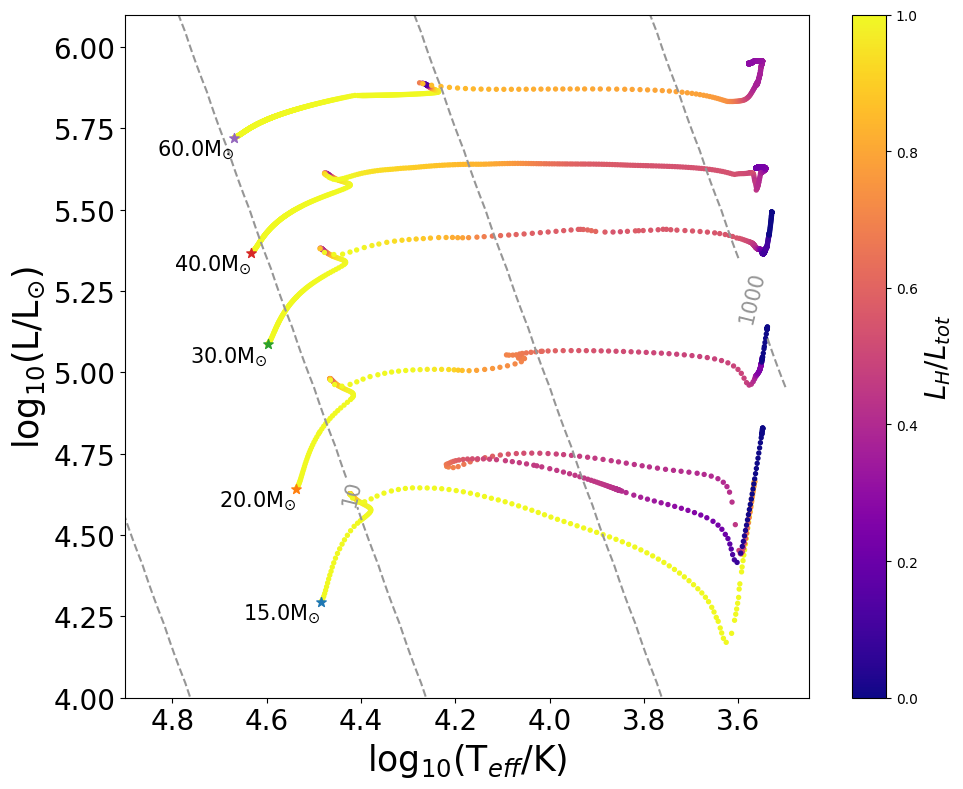

In [129]:
HR_diagram(histoy_list,
           xlim=(3.45, 4.9), ylim=(4.0, 6.1),
           VMIN=0, VMAX=1, cmap_name = 'plasma', Lfrac=True,
           colour_by='log_LH', colour_label='$L_{H}$/$L_{tot}$')


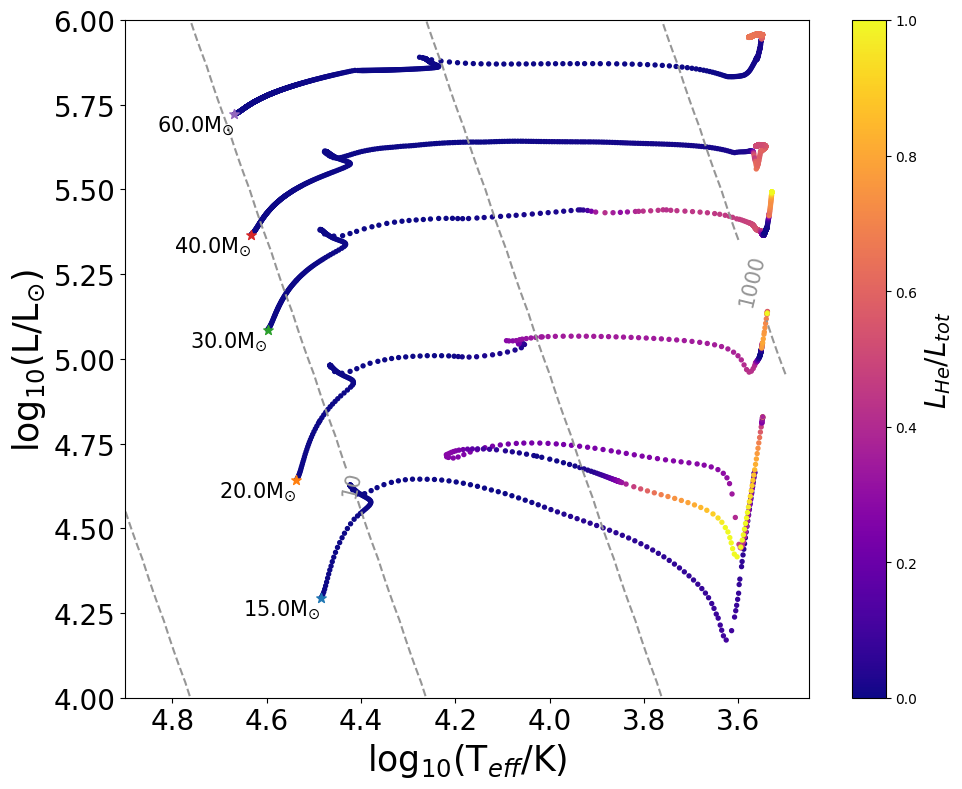

In [130]:
# make plot
HR_diagram(histoy_list, xlim = (3.45,4.9), ylim= (4.,6.), VMIN =0, VMAX = 1,
         Lfrac = True, colour_by = 'log_LHe', 
          cmap_name = 'plasma', colour_label = '$L_{He}$/$L_{tot}$')


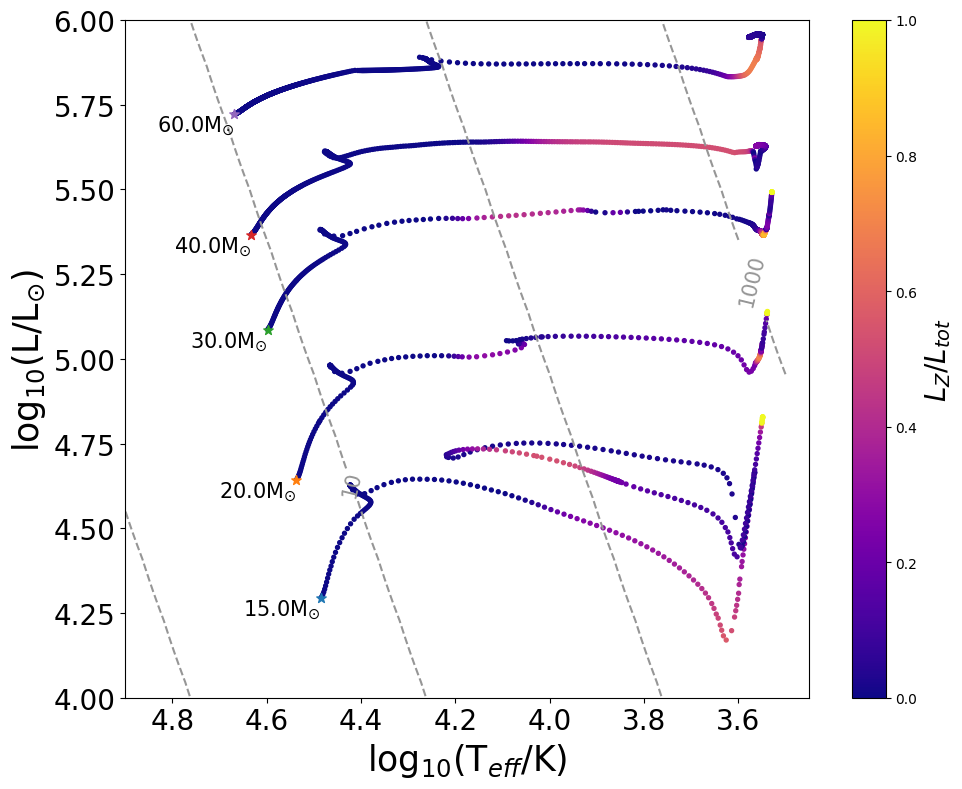

In [131]:
# make plot
HR_diagram(histoy_list, xlim = (3.45,4.9), ylim= (4.,6.), VMIN =0, VMAX = 1, 
            Lfrac = True, colour_by = 'log_LZ', 
            cmap_name = 'plasma', colour_label = '$L_{Z}$/$L_{tot}$')

## Now we'll show it per dominating Luminosity

Using dominant luminosity for colour, ignoring colour_by and Lfrac
Using dominant luminosity for colour, ignoring colour_by and Lfrac
Using dominant luminosity for colour, ignoring colour_by and Lfrac
Using dominant luminosity for colour, ignoring colour_by and Lfrac
Using dominant luminosity for colour, ignoring colour_by and Lfrac


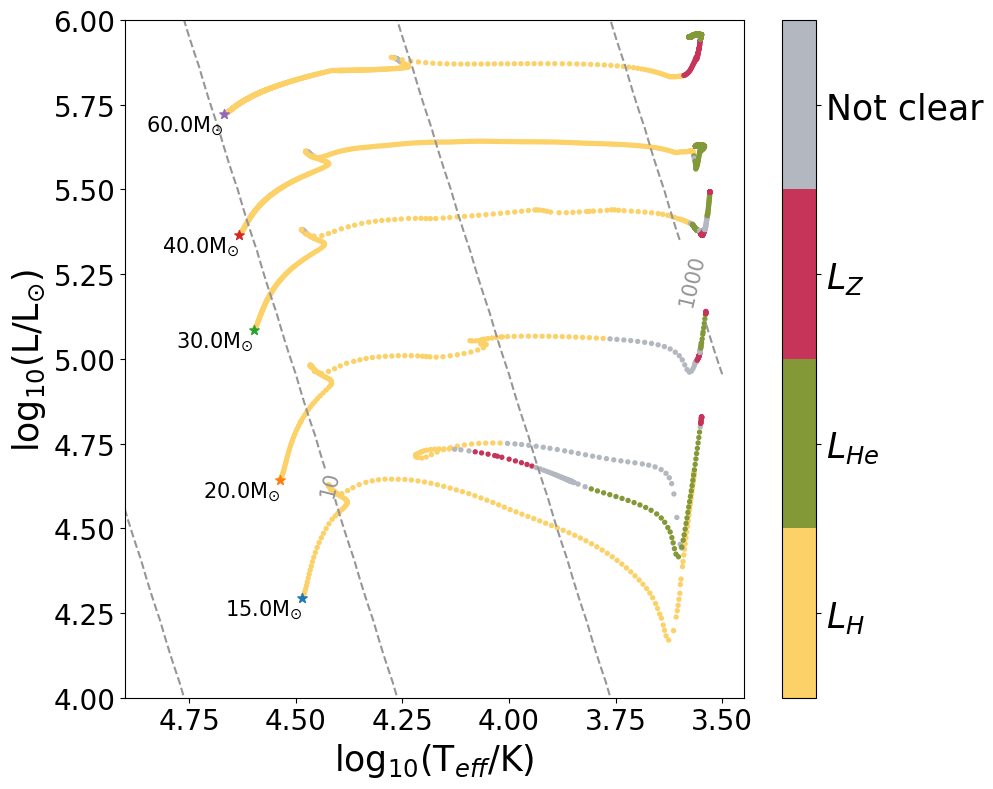

In [132]:
# make plot
HR_diagram(histoy_list, xlim = (3.45,4.9), ylim= (4.,6.), VMIN =-0.5, VMAX = 3.5,
            Lfrac = False, Ldominant = True,  colour_by = 'log_LZ', 
            cmap_name = 'plasma', colour_label = 'Dominant L source',)

## c) 
Here we're examining the amount of energy production that is exclusively due to the fusion of hydrogen, helium, and metals (everything more massive) in high mass star.  All our models are evolved up to the end of core carbon burning.
In the last plot where points are coloured according to the dominant source of energy production, we have defined the luminosity being "dominant" if it provides at least $50%$ of the stars Luminosity.
There is no clearly dominant source (defined here as one Luminosity contributes more than 50\% of the total luminosity) for significant stretches of the evolution.

We see that hydrogen fusion luminosity dominates during the main sequence (MS), as expected. After stars move along to their post MS phases, helium fusion begins to contribute on a similar level, but only truly dominates the luminosity around the giant branch.
We also note how for increasing stellar mass, larger parts of the HR diagram are purely dominated by H burning luminosity. 
This shows that hydrogen (shell) burning  is the dominant source of the stars luminosity through most of its evolution. 


We further observe a blue loop for the 15Msun star: you can see He ignites at te tip of the giant branch: the star is mostly convective here and moves down the hayashi line. When the star's envelope has become radiative again, it leaves the giant branch and becomes hotter. This being a hig-mass star, it actually moves to quite high temperatures before turing around again and H-shel burning luminosity dominates. 
Although metal fusion (i.e. carbon burning) only really become dominant sources briefly near the end of the evolution for most stars, we also find it also briefly dominates the stars luminosity of the 15Msun star in the blue loop. 

***
# 2 Evolution of massive stars with mass loss

In [134]:
# Read in the new data for our higher mass star with mass loss
M50_DSF1_hist_data = mr.MesaData('data/session3_workingdir/M50_overshoot0_DSF1p0/history.data')
M50_DSF05_hist_data = mr.MesaData('data/session3_workingdir/M50_overshoot0_DSF0p5/history.data')
M50_DSF01_hist_data = mr.MesaData('data/session3_workingdir/M50_overshoot0_DSF0p1/history.data')

# print(M50_DSF1_hist_data.bulk_names)

In [21]:
def plot_HR_with_radius_contours(list_of_hist_data, label_list = ['No overshoot', 'Overshoot 0.25', 'Overshoot 0.5'],
                                 save_path='plots/HR_diagram_overshoot.png',
                                 xlim=(4.5, 3.5), ylim=(3, 4.5)):
    """Plot an HR diagram with constant radius contours and MESA track overlays.
    
    Parameters:
       list_of_hist_data =  [f0_hist_data, f025_hist_data, f05_hist_data] : MesaData]
       save_path : str Where to save the output plot.
       xlim :x-axis (log Teff) limits. Default: (4.5, 3.5) for HR diagram.
       ylim : y-axis (log L) limits. Default: (3, 4.5)
    """
    
    def Radius(Teff, L):
        Teff = Teff * u.K
        L = (L * u.Lsun).to(u.W)
        R = (L / (4 * np.pi * const.sigma_sb * Teff**4))**0.5
        return R.to(u.Rsun).value

    fig, ax = plt.subplots(figsize=(9, 8))

    # --- Radius contour grid ---
    Teffs = np.linspace(1.5, 8, 100)
    Ls = np.linspace(2.0, 6.0, 100)
    Teffs_grid, Ls_grid = np.meshgrid(Teffs, Ls)
    Radius_grid = Radius(10**Teffs_grid, 10**Ls_grid)

    CS = ax.contour(Teffs_grid, Ls_grid, Radius_grid,
                    levels=[1, 10, 100, 1e3, 1e4],
                    colors='#969696', linestyles='dashed')
    ax.clabel(CS, inline=1, inline_spacing=-5, fontsize=15,
              manual=[(4.5, 3.2), (3.9, 3.2), (3.5, 3.2), (2.5, 3.2), (1.5, 3.1)])

    # --- MESA tracks ---
    for histdata, label, color in zip(
        list_of_hist_data,
        label_list,
        ['royalblue', 'green', 'crimson']
    ):
        ax.plot(histdata.log_Teff, histdata.log_L, label=label, color=color)

    # --- Axis setup ---
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel(r'$\log T_{\mathrm{eff}}$', fontsize=25)
    ax.set_ylabel(r'$\log L/L_{\odot}$', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)

    ax.legend(fontsize=15)

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()



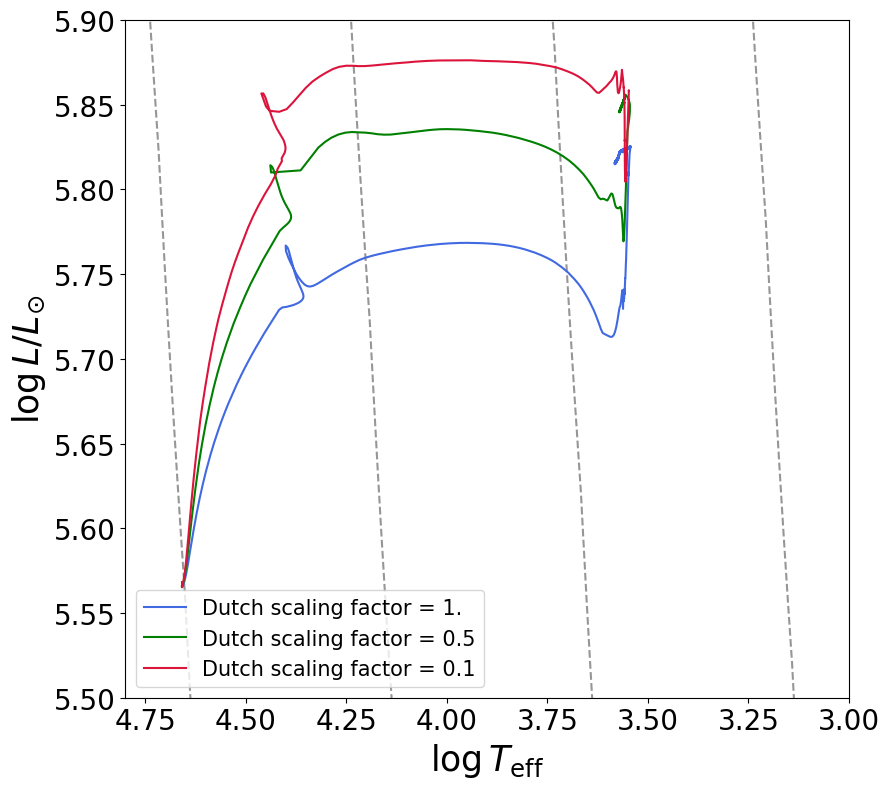

In [22]:
plot_HR_with_radius_contours(list_of_hist_data = [M50_DSF1_hist_data, M50_DSF05_hist_data, M50_DSF01_hist_data],
                            label_list = ['Dutch scaling factor = 1.', 'Dutch scaling factor = 0.5', 'Dutch scaling factor = 0.1'],
                            save_path='plots/M50_HR_diagram_winds.png',
                            xlim=(4.8, 3), ylim=(5.5, 5.9)
                            )



### Helium abundance versus stellar age

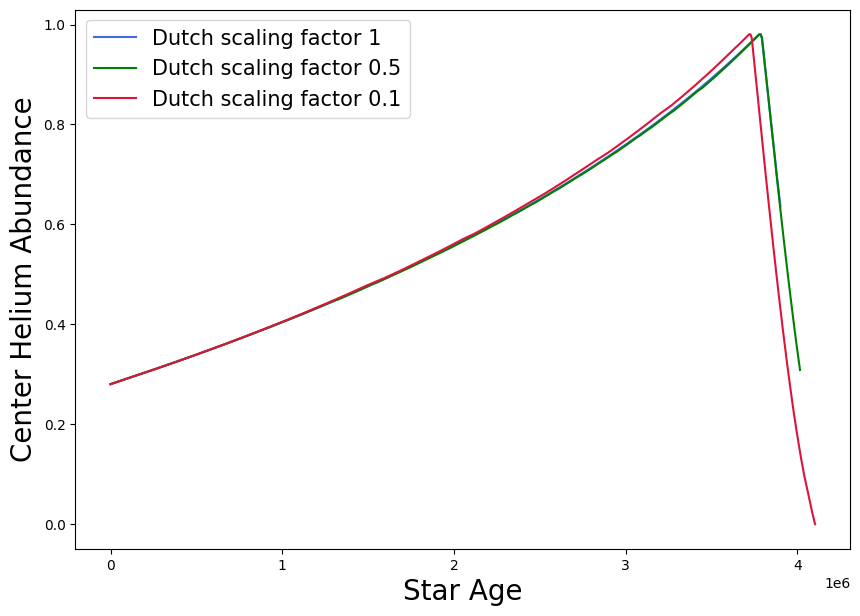

In [136]:
fig, ax = plt.subplots(figsize = (10,7))

##########
# Select the data to plot
for histdata, label, colors in zip([M50_DSF1_hist_data, M50_DSF05_hist_data, M50_DSF01_hist_data],
                                 ['Dutch scaling factor 1', 'Dutch scaling factor 0.5', 'Dutch scaling factor 0.1'],
                                 ['royalblue', 'green', 'crimson']):
    plt.plot(histdata.star_age, histdata.center_he4, label = label, color = colors)

# 'log_center_T', 'log_center_Rho',
plt.legend(fontsize = 15)
plt.xlabel("Star Age", fontsize = 20 )
plt.ylabel("Center Helium Abundance", fontsize = 20 )
plt.savefig('plots/M50_central_He.png', bbox_inches = 'tight')
plt.show()

Core properties didn't change much when changing the winds (which is an external thing!)

### Plot surface abundances

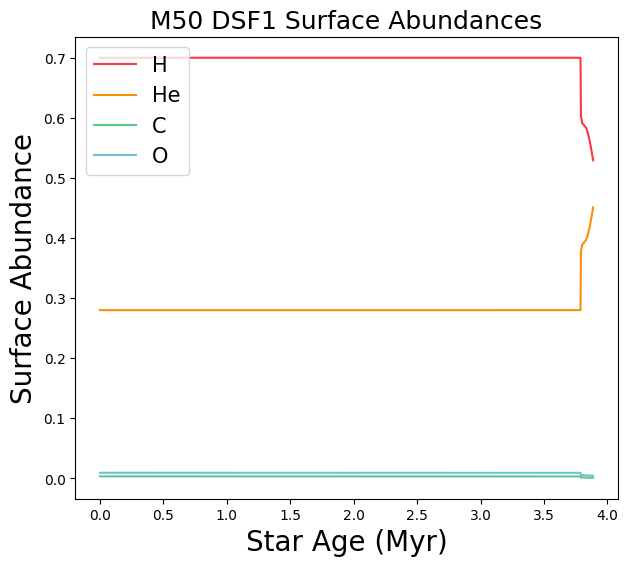

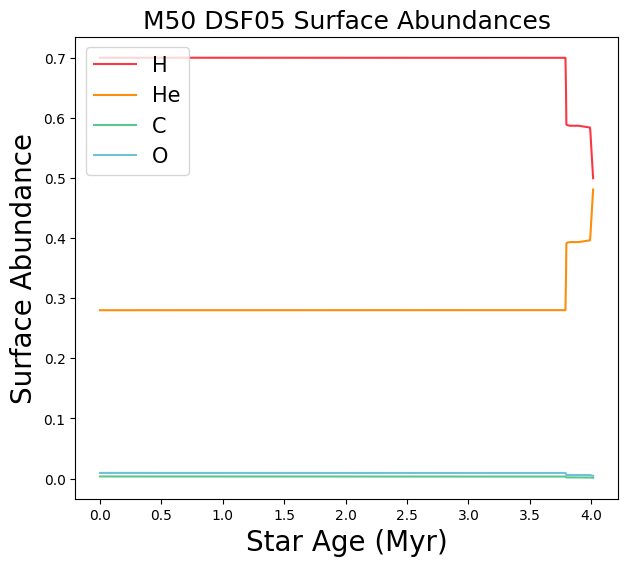

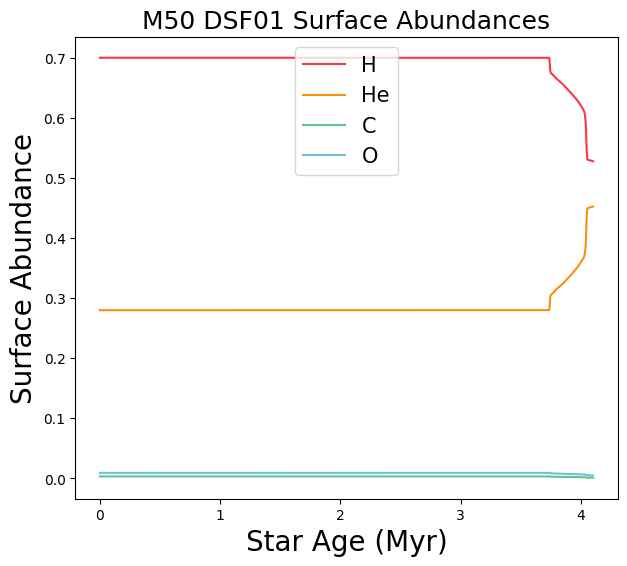

In [ ]:
def plot_surface_abundances(histdata, var_name = 'DSF05'):
    fig, ax = plt.subplots(figsize = (7,6))

    ##########
    # Select the data to plot
    plt.plot(histdata.star_age*1e-6, histdata.surface_h1, label = 'H', color = '#FB3743')
    plt.plot(histdata.star_age*1e-6, histdata.surface_he4, label = 'He', color = '#FB8E0C')
    plt.plot(histdata.star_age*1e-6, histdata.surface_c12, label = 'C', color = '#5CC68E')
    plt.plot(histdata.star_age*1e-6, histdata.surface_o16, label = 'O', color = '#71C1D6')

    plt.title(f"M50 {var_name} Surface Abundances", fontsize = 18)
    plt.legend(fontsize = 15)
    plt.xlabel("Star Age (Myr)", fontsize = 20 )
    plt.ylabel("Surface Abundance", fontsize = 20 )
    plt.savefig(f'plots/M50_{var_name}_surface_abundances.png', bbox_inches = 'tight')
    plt.show()

plot_surface_abundances(M50_DSF1_hist_data, var_name='DSF1')
plot_surface_abundances(M50_DSF05_hist_data, var_name='DSF05')
plot_surface_abundances(M50_DSF01_hist_data, var_name='DSF01')



Surface abundances change much more when you change the winds! I.e. with stronger winds, the stars become less H rich and more He rich in their envelope. 

### Extra: abundance profile beyond core He exhaust:

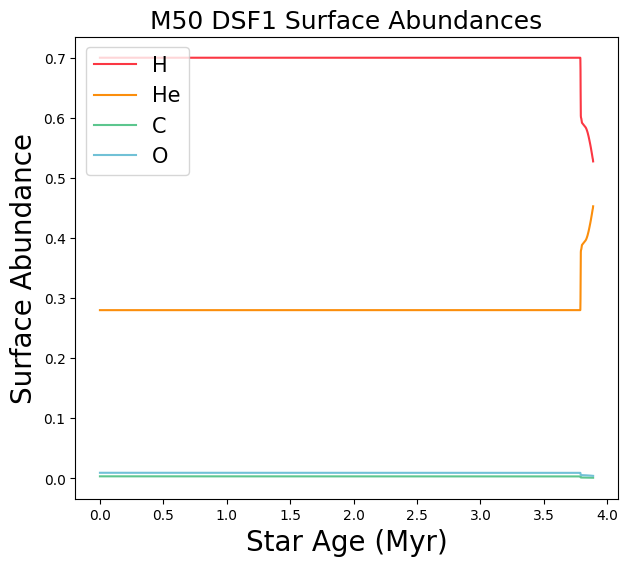

In [ ]:
# Re-read in to load the newest data
M50_DSF1_hist_data = mr.MesaData('data/M50_overshoot0_DSF1p0/LOGS/history.data')

# Plot it
plot_surface_abundances(M50_DSF1_hist_data, var_name='DSF1')


# Problem 2b Surface abundances

In [ ]:
history60_Dutch.info()

<Table length=763>
         name           dtype 
---------------------- -------
          model_number   int64
             num_zones   int64
              star_age float64
                log_dt float64
             star_mass float64
            log_xmstar float64
          log_abs_mdot float64
        mass_conv_core float64
          conv_mx1_top float64
          conv_mx1_bot float64
          conv_mx2_top float64
          conv_mx2_bot float64
               mx1_top float64
               mx1_bot float64
               mx2_top float64
               mx2_bot float64
                log_LH float64
               log_LHe float64
                log_LZ float64
              log_Lnuc float64
    log_Lnuc_sub_log_L float64
                    pp float64
                   cno float64
              tri_alfa float64
            epsnuc_M_1 float64
            epsnuc_M_2 float64
            epsnuc_M_3 float64
            epsnuc_M_4 float64
            epsnuc_M_5 float64
            epsnuc_M

In [ ]:
def plot_abundance_time(histoy_list, abund = 'surface_he4', ylab = 'He 4'):
    ###############
    ### start Figure
    fig, ax = plt.subplots(figsize=(14,10))
        
    ###############
    for i, hist in enumerate(histoy_list):
        ## Remove pre-MS
        # find index of first occurence of center_h < 70 (= primordial )
        ZAMS_i = next(ind for ind,x in enumerate(hist['center_h1']) if x < 0.69)
        hist = hist[ZAMS_i:]
        
        plt.plot(hist['star_age']/hist['star_age'][-1], hist[abund], 
                 label = np.str(np.round(hist['star_mass'][0],0))+'M$_{\odot}$')

    # Plot values
    ax.set_xlabel('fraction of star age to $^{12}$C exhaustion')
    ax.set_ylabel('surface abundance ' + ylab)
    plt.tick_params(axis='both', which='major')
    plt.xlim(0.8, 1.0)
#     plt.ylim(ylim)
    plt.yscale('log')

    plt.legend( )
    plt.savefig(save_loc +'/surfaceAbund'+abund+'.png', bbox_inches='tight')    
    plt.show()
    plt.close()


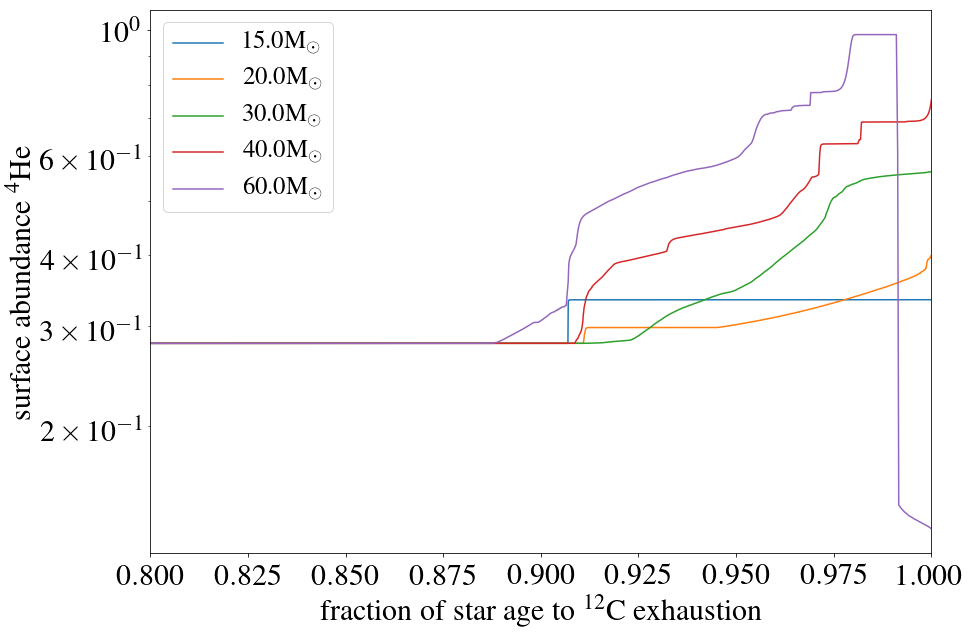

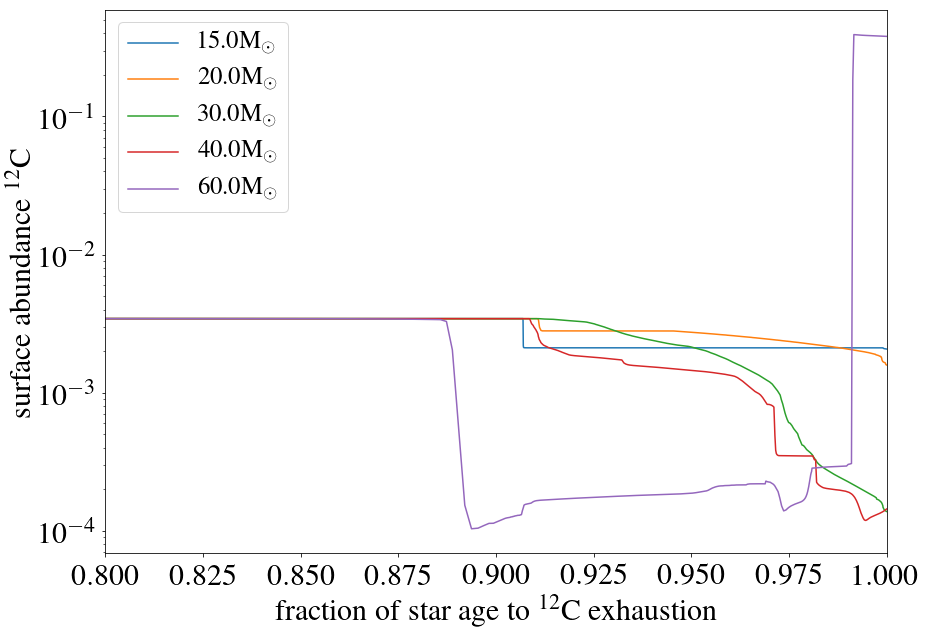

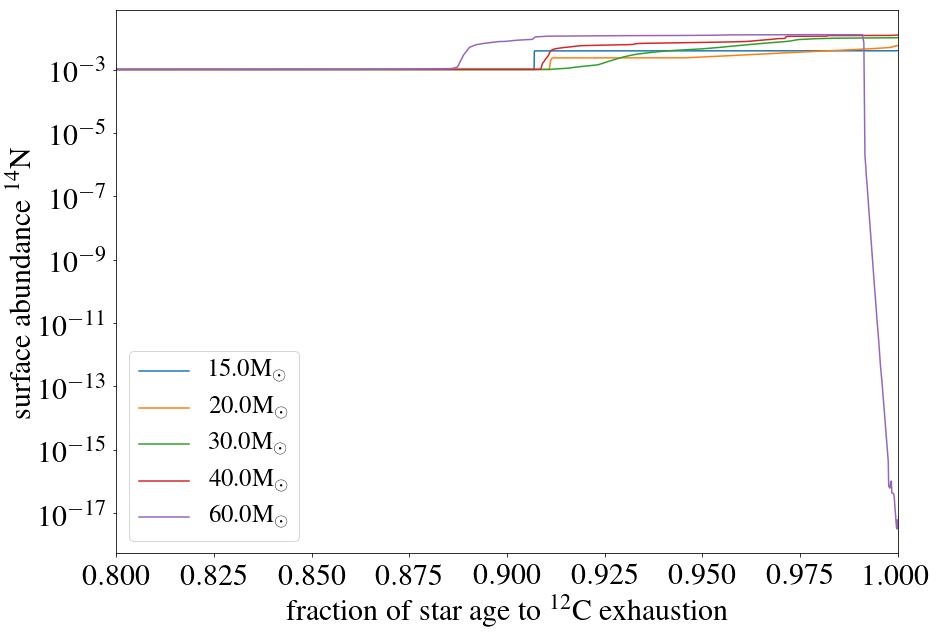

In [ ]:
plot_abundance_time(histoy_list, abund = 'surface_he4', ylab = '$^{4}$He')
plot_abundance_time(histoy_list, abund = 'surface_c12', ylab = '$^{12}$C')
plot_abundance_time(histoy_list, abund = 'surface_n14', ylab = '$^{14}$N')

In [ ]:

#Plot the HR diagram with different colour values
def HR_diagram(histoy_list, xlim = (None, None), ylim = (None,None),  VMIN =-3, VMAX = 0,
               colour_by = 'center_h1', colour_label = 'kleur',save_loc = proj_dir + '/hw4sol/plots/'):
    
    kleur = colour_by
    ###############
    ### start Figure
    fig, ax = plt.subplots(figsize=(14,10))
        
    ###############
    for i, hist in enumerate(histoy_list):
        ## Remove pre-MS
        # find index of first occurence of center_h < 70 (= primordial )
        ZAMS_i = next(ind for ind,x in enumerate(hist['center_h1']) if x < 0.69)
        hist = hist[ZAMS_i:]
        
        #Extra column
        hist['N_C'] = hist['surface_n14']/hist['surface_c12']
            
        ##plot lines
        scat = ax.scatter(hist['log_Teff'],  hist['log_L'] , label= hist_names[i],
                c = hist[kleur], vmin= VMIN, vmax = VMAX)
        ax.scatter(hist['log_Teff'][0],  hist['log_L'][0] , marker = '*') #log_Teff
        ax.text(hist['log_Teff'][0],  hist['log_L'][0] , hist_names[i], ha='right', va='top') #log_Teff

    ###############
    ### Add lines of constant radii
    log_Ts = np.arange(min(hist['log_Teff'])-2, max(hist['log_Teff'])+2, 0.1) #Array of log temperature values
    for i, logr in enumerate([-1,0,1,2,3]): #Loop over radii
        ax.plot(log_Ts, const_Rlines(log_Ts, logr), c='k', alpha = 0.3, linestyle='--')
        # Plot text
        ax.text(4.2, const_Rlines(4.2, logr), 'R = '+ str(np.round( 10**logr,2) ) +' R$_{\odot}$',
                 rotation=-60, alpha = 0.2).set_clip_on(True)
     
    #colorbar
    cb = fig.colorbar(scat, ax=ax)
    cb.set_label(colour_by.replace('_', ' '), size = 25)
    cb.set_label(colour_label, size = 25)
    cb.ax.tick_params(labelsize=20)
    
    # Show WR region
    WR_i1 = next(ind for ind,x in enumerate(history40_Dutch['surface_h1']) if x < 0.3)
    WR_i2 = next(ind for ind,x in enumerate(history60_Dutch['surface_h1']) if x < 0.3)
    T_array = np.linspace(history40_Dutch['log_Teff'][WR_i1]+0.05, 4., num =50)

    dx = history40_Dutch['log_Teff'][WR_i1] - history60_Dutch['log_Teff'][WR_i2]
    dy = history40_Dutch['log_L'][WR_i1] - history60_Dutch['log_L'][WR_i2]
    y_line = (dy/dx)*T_array + 16
    plt.plot(T_array, y_line , c = 'pink')
    plt.fill_between(x = T_array, y1 =y_line, y2 = 7,zorder = 0,
                     color='r',alpha=0.1,edgecolor='blue',hatch='/', lw = 0)
    plt.fill_between(x = np.linspace(6,history40_Dutch['log_Teff'][WR_i1]+0.05),zorder = 0,
                     y1 =y_line[0], y2 = 7,color='r',alpha=0.1,edgecolor='blue',hatch='/', lw = 0.0)
    
    
    # Plot values
    ax.set_ylabel('log$_{10}$(L/L$_{\odot}$)')
    ax.set_xlabel('log$_{10}$(T$_{eff}$/K)')
    plt.tick_params(axis='both', which='major')
    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.gca().invert_xaxis()    
#     plt.legend( )
    plt.savefig(save_loc +'/HR_'+colour_by+'.png', bbox_inches='tight')    
    plt.show()
    plt.close()




In [ ]:
histoy_list = [history15_Dutch, history20_Dutch, history30_Dutch, history40_Dutch, history60_Dutch]
HistNameList   = ['15 M$_{\odot}$', '20 M$_{\odot}$', '30 M$_{\odot}$', '40 M$_{\odot}$', '60 M$_{\odot}$']
colors = plt.cm.plasma(np.linspace(0,1,4)) #3rd num is the number of colours Set2

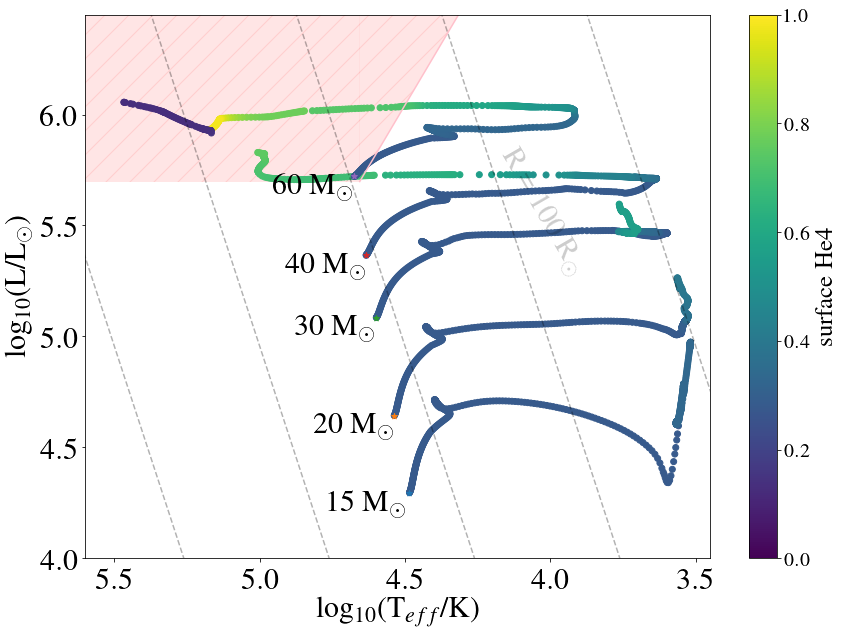

In [ ]:
# He
HR_diagram(histoy_list, xlim = (3.45,5.6), ylim= (4.,6.45), VMIN =0, VMAX = 1,
           colour_by = 'surface_he4', colour_label = 'surface He4')

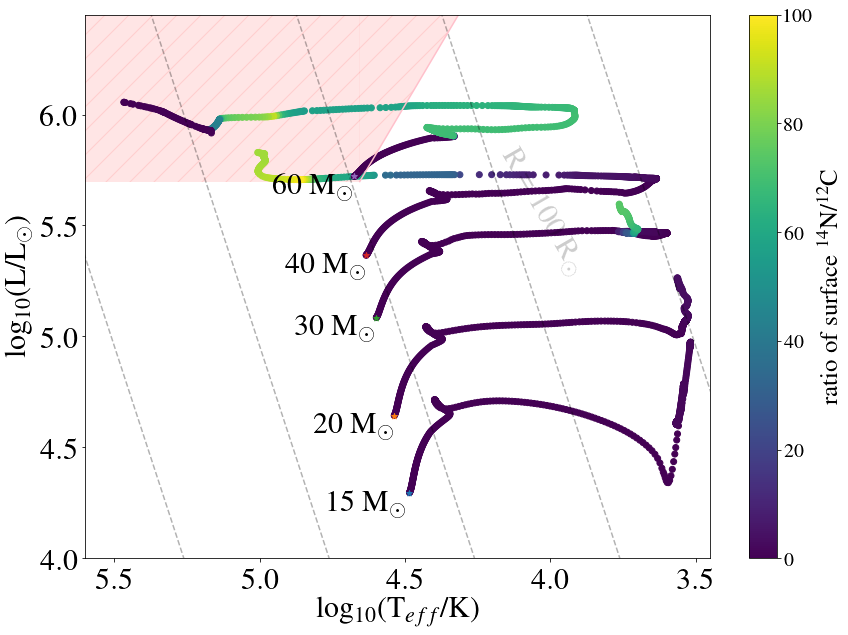

In [ ]:
# ratio Nitrogen over Carbon
HR_diagram(histoy_list, xlim = (3.45,5.6), ylim= (4.,6.45), VMIN =0, VMAX = 100,
           colour_by = 'N_C', colour_label = 'ratio of surface $^{14}$N/$^{12}$C')

# surface_h1 < 0.3


***
# 3 Radius evolution of massive stars

In [2]:
history50 = mr.MesaData('./data/session3_work/LOGS/history.data')
# history50.bulk_names


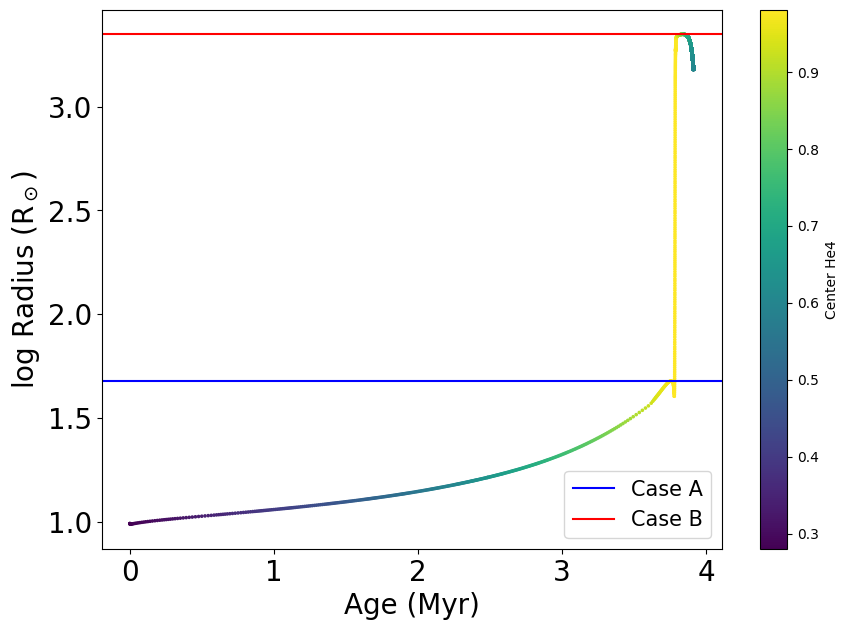

In [3]:
fig, ax = plt.subplots(figsize = (10,7))

plt.scatter(history50.star_age *1e-6, history50.log_R,
            c = history50.center_he4, s = 2.5)

plt.colorbar(label = 'Center He4')
    
plt.axhline(1.68, label = 'Case A', color = 'blue')
plt.axhline(3.35, label = 'Case B', color = 'r')

plt.xlabel('Age (Myr)', fontsize =20)
plt.ylabel('log Radius (R$_\odot$)', fontsize =20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.legend(fontsize = 15)
plt.savefig('plots/Radius_vs_Time.png')

plt.show()  

## b) 
Assuming that the initial separations are distributed flat in log separation, we can directly map the vertical space in logR to the probability of interacting during a certain phase of expansion. 
We see that Case B mass transfer (during the HG) clearly causes the largerst radius increase and is thus the most likely kind of interaction.

In [4]:
print(f"Case A below {10**1.68} Rsun")
print(f"Case B below {10**3.35} Rsun")
print(f"Case C below {10**1.68} Rsun ")


Case A below 47.86300923226383 Rsun
Case B below 2238.72113856834 Rsun
Case C below 47.86300923226383 Rsun 


## c) 
Case A is for any radius up to about 50Rsun, Case B between 50 and about 2200 Rsun and Case C any expansion beyond 2200 Rsun

(4.7, 3.5)

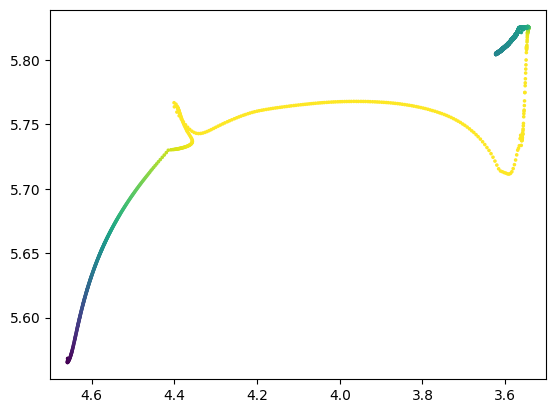

In [5]:
plt.scatter(history50.log_Teff, history50.log_L,
            c = history50.center_he4, s = 2.5)
plt.xlim(4.7, 3.5)
